##Import statements and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import cartopy.crs as ccrs

from matplotlib import pyplot as plt
from cartopy.io.img_tiles import MapboxTiles

%matplotlib inline

In [2]:
INPUT_FILE = '../data/trip_data_1_half.csv'
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

START_HOUR = 15
END_HOUR   = 20

LAT_MIN, LAT_MAX = 40.76041, 40.76507
LON_MIN, LON_MAX = -73.98164, -73.97653

# Load data
td = pd.read_csv(INPUT_FILE)

# Convert to correct datatypes
td['pickup_datetime'] = pd.to_datetime(td['pickup_datetime'])
td['dropoff_datetime'] = pd.to_datetime(td['dropoff_datetime'])

# Filter based on starting time
td = td[(td['pickup_datetime'].dt.hour >= START_HOUR) & (td['pickup_datetime'].dt.hour < END_HOUR)]

# Filter based on location
td = td[(td['pickup_longitude'] >= LON_MIN) &
        (td['pickup_longitude'] <= LON_MAX) &
        (td['pickup_latitude']  >= LAT_MIN) &
        (td['pickup_latitude']  <= LAT_MAX)]

print "Trips: " + str(len(td))

Trips: 30950


In [3]:
# Cut off long tail
td=td[td['trip_time_in_secs'] < 1500]

dropoff_lat = np.asarray(td['dropoff_latitude'], dtype=np.float)
dropoff_lon = np.asarray(td['dropoff_longitude'], dtype=np.float)
trip_time = np.asarray(td['trip_time_in_secs'], dtype=np.int)

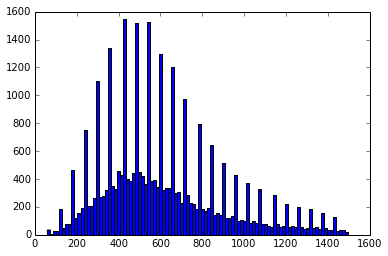

In [4]:
plt.hist(trip_time,bins=100)
plt.show()

##Plot a map color-coding with trip times 

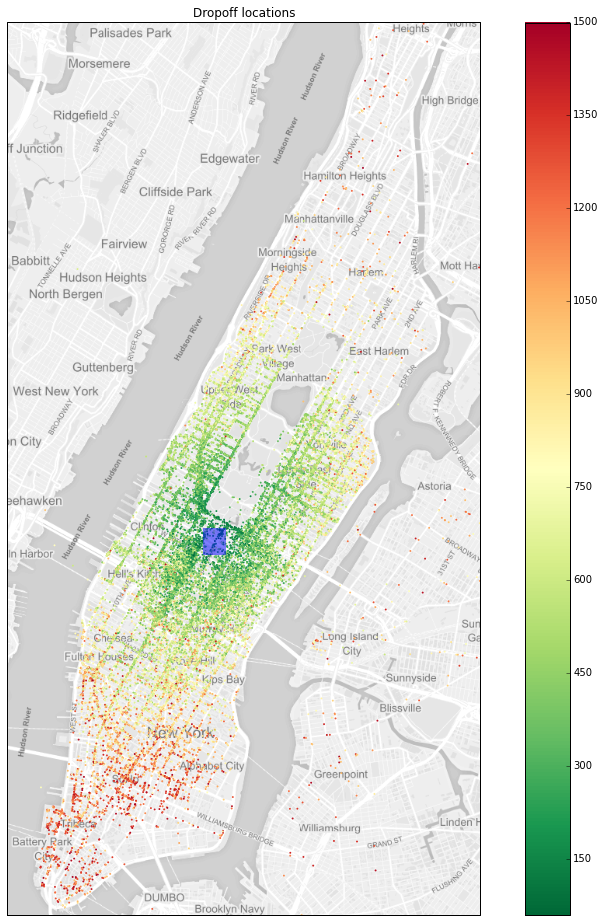

In [5]:
# Add a map using a mapbox template
mapbox_token = 'pk.eyJ1IjoiY2hlbnlhbmciLCJhIjoiNjAwYTI1MDExNDdmYzVkZWY0M2NkNjQyMDJkZjhkOTMifQ.G7P8sFypgRqFW2QNaEZocQ'
mapbox_mapid = 'chenyang.e39eae3e'

tiles = MapboxTiles(mapbox_token, mapbox_mapid)
plt.figure(figsize=(16, 16))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=tiles.crs)

# Specify a region of interest, in this case, Manhattan.
ax.set_extent([-74.025, -73.92, 40.70, 40.85],
              ccrs.PlateCarree())

# Add the tiles at zoom level 13.
ax.add_image(tiles, 13)

# Plot destinations, color coded by travel times
sc = ax.scatter(dropoff_lon, dropoff_lat, 
                marker='.', s=15, lw=0, 
                c=trip_time, cmap=cm.RdYlGn_r,
                transform=ccrs.PlateCarree())

# Plot the origin area
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((LON_MIN, LAT_MIN), LON_MAX-LON_MIN, LAT_MAX-LAT_MIN, 
                       facecolor="blue", alpha=0.5, lw=0,
                       transform=ccrs.PlateCarree()))

# Scale and labels
plt.colorbar(sc)
plt.title('Dropoff locations')

plt.show()